In [8]:
!pip install missingno

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [9]:
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split
from missforest import MissForest
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import shap
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [10]:
pd.read_csv('../data/raw/AB_NYC_2019.csv')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [11]:
df = pd.read_csv('../data/raw/AB_NYC_2019.csv', index_col='id')
pd.set_option('display.max_columns', None)
df.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [12]:
unicos = df.nunique()
df[unicos[unicos==1].index]

""
id
2539
2595
3647
3831
5022
...
36484665
36485057
36485431


In [13]:
df.drop(unicos[unicos==1].index, axis=1, inplace=True)

In [14]:
df.shape

(48895, 15)

In [15]:
df.T.duplicated().sum()

np.int64(0)

In [16]:
df.T.duplicated(keep=False)

name                              False
host_id                           False
host_name                         False
neighbourhood_group               False
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
last_review                       False
reviews_per_month                 False
calculated_host_listings_count    False
availability_365                  False
dtype: bool

In [17]:
#Eliminar columnas redundantes
df.drop(['availability_365', 'calculated_host_listings_count', 'host_name'], axis=1, inplace=True)

In [18]:
pd.read_csv('../data/raw/AB_NYC_2019.csv')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [19]:
df.shape

(48895, 12)

In [20]:
faltantes = df.isna().mean()*100
faltantes[faltantes>0]

name                  0.032723
last_review          20.558339
reviews_per_month    20.558339
dtype: float64

In [22]:
df.isnull().any(axis=1).sum()

np.int64(10058)

In [75]:
n = 2
filas_con_n_faltantes = df[df.isnull().sum(axis=1) == n]
print(f"\nFilas con exactamente {n} valores faltantes:")
print(filas_con_n_faltantes)


Filas con exactamente 2 valores faltantes:
                                                       name   host_id  \
id                                                                      
3647                    THE VILLAGE OF HARLEM....NEW YORK !      4632   
7750                      Huge 2 BR Upper East  Cental Park     17985   
8700      Magnifique Suite au N de Manhattan - vue Cloitres     26394   
11452                           Clean and Quiet in Brooklyn      7355   
11943                             Country space in the city     45445   
...                                                     ...       ...   
36484665    Charming one bedroom - newly renovated rowhouse   8232441   
36485057      Affordable room in Bushwick/East Williamsburg   6570630   
36485431            Sunny Studio at Historical Neighborhood  23492952   
36485609               43rd St. Time Square-cozy single bed  30985759   
36487245  Trendy duplex in the very heart of Hell's Kitchen  68119814   

      

<Axes: >

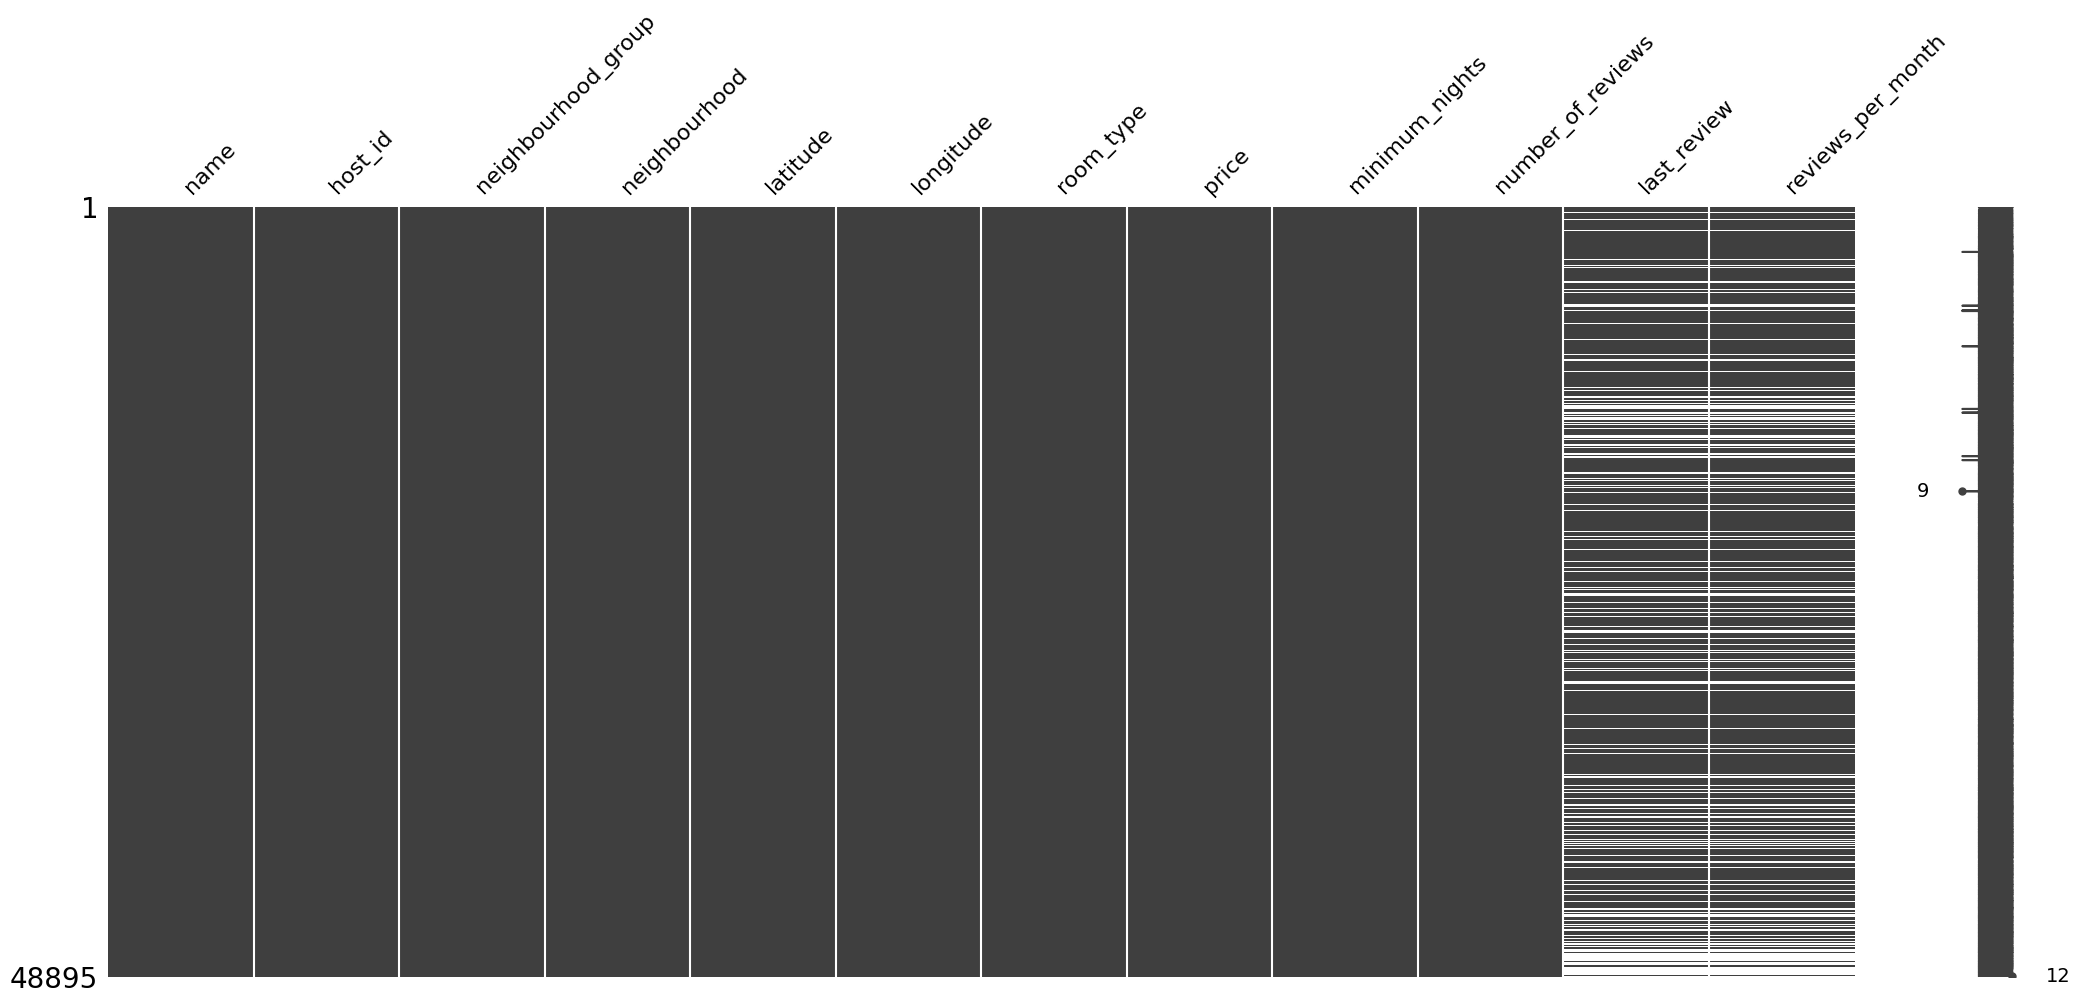

In [24]:
msno.matrix(df)

In [76]:
X = X.dropna()
y = y[X.index]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [28]:
X_train_imp = X_train.copy()
X_test_imp = X_test.copy()

print(f"Train: {X_train_imp.shape}")
print(f"Test: {X_test_imp.shape}")

Train: (31074, 10)
Test: (7769, 10)


In [63]:
X_train[['last_review','reviews_per_month']]

,last_review,reviews_per_month
id,,
12652765,2016-05-14,0.05
28108959,2019-06-20,1.74
4841431,2016-05-08,0.80
31315168,2019-06-30,2.82
36019067,2019-06-29,1.00
...,...,...
5050156,2019-05-26,0.28
10037800,2016-09-18,0.06
35376285,2019-06-26,1.00


In [74]:
X_train['last_review'].value_counts(normalize=True)*100

last_review
2019-06-23    3.716934
2019-07-01    3.459484
2019-06-30    3.404776
2019-06-24    2.204415
2019-07-07    1.811804
                ...   
2015-04-11    0.003218
2013-12-14    0.003218
2014-12-26    0.003218
2014-07-15    0.003218
2014-04-22    0.003218
Name: proportion, Length: 1705, dtype: float64

In [65]:
X_train['reviews_per_month'].value_counts(normalize=True)*100

reviews_per_month
0.05     2.329922
0.02     2.307395
1.00     2.307395
0.03     2.072472
0.16     1.718478
           ...   
9.74     0.003218
6.42     0.003218
17.82    0.003218
8.50     0.003218
6.58     0.003218
Name: proportion, Length: 899, dtype: float64

In [78]:
#convertir valores NaN a 0

df['reviews_per_month'].fillna(0, inplace=True)
pd.set_option('display.max_columns', None)
df.head()

/tmp/ipykernel_16423/2746963575.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews_per_month'].fillna(0, inplace=True)


,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,fecha_num
id,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,1539907200000000000
2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,1558396800000000000
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,0.00,-9223372036854775808
3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1562284800000000000
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1542585600000000000


In [79]:
# Ver si tienes valores faltantes
print("Valores faltantes totales:", X_train.isnull().sum().sum())
print("\nValores faltantes por columna:")
print(X_train.isnull().sum())

Valores faltantes totales: 0

Valores faltantes por columna:
host_id                0
neighbourhood_group    0
neighbourhood          0
latitude               0
longitude              0
room_type              0
minimum_nights         0
number_of_reviews      0
last_review            0
reviews_per_month      0
dtype: int64


In [67]:
#codificar variables categoricas
cat_cols = X_train_imp.select_dtypes(include=['object']).columns.tolist()
print(f"Columnas categóricas encontradas: {cat_cols}")

# Codificar TRAIN
X_train_encoded = pd.get_dummies(X_train_imp, columns=cat_cols, drop_first=True)
print(f" Train codificado: {X_train_encoded.shape}")

# Codificar TEST (asegurar mismas columnas que train)
X_test_encoded = pd.get_dummies(X_test_imp, columns=cat_cols, drop_first=True)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
print(f" Test codificado: {X_test_encoded.shape}")

Columnas categóricas encontradas: ['neighbourhood_group', 'neighbourhood', 'room_type', 'last_review']
 Train codificado: (31074, 1931)
 Test codificado: (7769, 1931)


In [68]:
X_train_imp = X_train.copy()
print(X_train_imp.shape)
X_train_imp.describe().T

(31074, 10)


,count,mean,std,min,25%,50%,75%,max
host_id,31074.0,6.404430e+07,7.582253e+07,2438.00000,6.987380e+06,2.797618e+07,1.014998e+08,2.738417e+08
latitude,31074.0,4.072802e+01,5.497201e-02,40.50641,4.068860e+01,4.072153e+01,4.076291e+01,4.091306e+01
longitude,31074.0,-7.395099e+01,4.651625e-02,-74.23986,-7.398225e+01,-7.395467e+01,-7.393475e+01,-7.371299e+01
minimum_nights,31074.0,5.883536e+00,1.796425e+01,1.00000,1.000000e+00,2.000000e+00,4.000000e+00,1.250000e+03
number_of_reviews,31074.0,2.938469e+01,4.845201e+01,1.00000,3.000000e+00,9.000000e+00,3.300000e+01,6.290000e+02
reviews_per_month,31074.0,1.376672e+00,1.687790e+00,0.01000,1.900000e-01,7.200000e-01,2.030000e+00,5.850000e+01


In [69]:
X_train_imp.shape

(31074, 10)

In [70]:
print("\nTipos de datos en X_train_encoded:")
print(X_train_encoded.dtypes.value_counts())

if 'object' in X_train_encoded.dtypes.values:
    print("ADVERTENCIA: Aún hay columnas tipo 'object'")
    print(X_train_encoded.select_dtypes(include=['object']).columns.tolist())
else:
    print("No hay columnas tipo 'object'")


Tipos de datos en X_train_encoded:
bool       1925
int64         3
float64       3
Name: count, dtype: int64
No hay columnas tipo 'object'


In [39]:
from xgboost import XGBRegressor

model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
model.fit(X_train_encoded, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [71]:
# Importancia de características
importances = model.feature_importances_/model.feature_importances_.sum()*100

# Convertir a DataFrame
df_rf_imp = pd.DataFrame({'feature': X_train_encoded.columns,'rf_importance': importances}).sort_values(by='rf_importance', ascending=False)

# Calculamos la importancia acumulada
df_rf_imp['rf_importance_acum'] = df_rf_imp['rf_importance'].cumsum()

In [72]:
df_rf_imp

,feature,rf_importance,rf_importance_acum
225,room_type_Private room,5.728771,5.728771
715,last_review_2016-02-13,5.235028,10.963799
22,neighbourhood_Bedford-Stuyvesant,5.031336,15.995134
70,neighbourhood_East Harlem,4.820446,20.815580
1637,last_review_2018-09-18,4.225570,25.041149
...,...,...,...
674,last_review_2015-12-28,0.000000,99.999969
673,last_review_2015-12-27,0.000000,99.999969
672,last_review_2015-12-26,0.000000,99.999969
671,last_review_2015-12-25,0.000000,99.999969


In [42]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

X_train1, X_val, y_train1, y_val = train_test_split(
    X_train_encoded,  #  Usar la versión codificada
    y_train, 
    test_size=0.2, 
    random_state=42
)


In [44]:
# Entrenar XGBoost
model_xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    n_jobs=-1
)

model_xgb.fit(X_train1, y_train1)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [49]:
df_perm_imp = pd.DataFrame({
    'feature': X_train1.columns, 
    'perm_imp': model_xgb.feature_importances_ * 100
}).sort_values('perm_imp', ascending=False)

df_perm_imp

,feature,perm_imp
225,room_type_Private room,7.521533
920,last_review_2016-09-15,7.016541
1929,last_review_2019-07-07,6.724657
3,minimum_nights,5.713636
1219,last_review_2017-07-27,3.790872
...,...,...
674,last_review_2015-12-28,0.000000
673,last_review_2015-12-27,0.000000
672,last_review_2015-12-26,0.000000
671,last_review_2015-12-25,0.000000


In [50]:
#SHAP

# Limpiar nombres de columnas (eliminar caracteres especiales)
X_train1.columns = X_train1.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
X_val.columns = X_val.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

#entrenar LightGBM
import lightgbm as lgb

model_lgb = lgb.LGBMRegressor(random_state=42)
model_lgb.fit(X_train1, y_train1)

print("LightGBM entrenado!")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1869
[LightGBM] [Info] Number of data points in the train set: 24859, number of used features: 275
[LightGBM] [Info] Start training from score 141.437749
LightGBM entrenado!


In [51]:
# Convertir booleanos a enteros (0 y 1)
X_train1 = X_train1.astype(int)
X_val = X_val.astype(int)

# Re-entrenar el modelo
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
model_xgb.fit(X_train1, y_train1)

# Ahora calcular SHAP
explainer = shap.Explainer(model_xgb, X_train1)
shap_vals = explainer(X_val)

print(" SHAP values calculados!")

 SHAP values calculados!


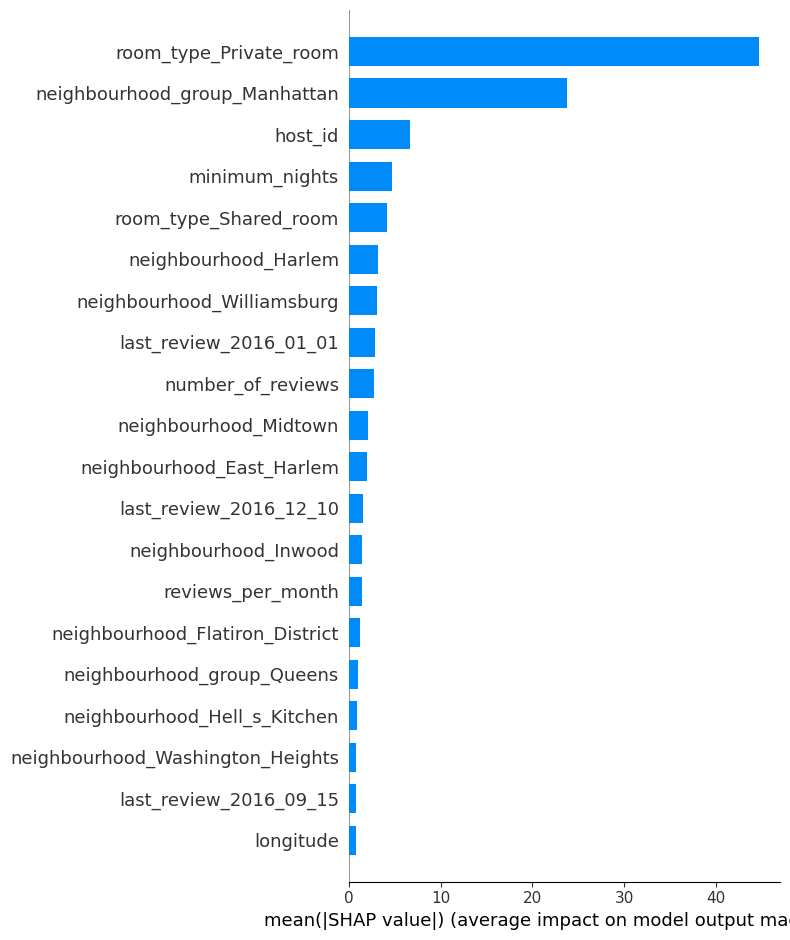

<Figure size 640x480 with 0 Axes>

In [52]:
# --- SHAP Summary Bar Plot ---
import shap
shap.summary_plot(shap_vals, X_val, plot_type="bar")
plt.tight_layout()
plt.show()

In [58]:
### Unión 3 métodos
# Unir los que existan
df_importances = df_perm_imp.copy()  # Empezar con uno que tengas

if 'df_shap_imp' in locals():
    df_importances = df_importances.merge(df_shap_imp, on='feature', how='outer')

df_importances = df_importances.sort_values('perm_imp', ascending=False)
df_importances

df_importances = (
    df_rf_imp
    .merge(df_perm_imp, on='feature', how='outer')
).sort_values('rf_importance', ascending=False)
df_importances

,feature,rf_importance,rf_importance_acum,perm_imp
1929,room_type_Private room,5.728771,5.728771,7.521533
489,last_review_2016-02-13,5.235028,10.963799,0.000000
1720,neighbourhood_Bedford-Stuyvesant,5.031336,15.995134,0.000056
1768,neighbourhood_East Harlem,4.820446,20.815580,2.019155
1411,last_review_2018-09-18,4.225570,25.041149,0.000000
...,...,...,...,...
654,last_review_2016-08-06,0.000000,99.999969,0.000000
653,last_review_2016-08-05,0.000000,99.999969,0.000000
652,last_review_2016-08-04,0.000000,99.999969,0.000000
651,last_review_2016-08-03,0.000000,99.999969,0.000000


In [61]:
df_filt = df_importances[(df_importances['rf_importance']>=1)&(df_importances['perm_imp']>=1)&(df_importances['rf_importance_acum']>=1)]
df_filt

,feature,rf_importance,rf_importance_acum,perm_imp
1929,room_type_Private room,5.728771,5.728771,7.521533
1768,neighbourhood_East Harlem,4.820446,20.815580,2.019155
1707,minimum_nights,3.828292,28.869440,5.713636
1703,last_review_2019-07-07,3.826241,32.695683,6.724657
694,last_review_2016-09-15,3.684239,36.379921,7.016541
993,last_review_2017-07-27,3.446298,39.826218,3.790872
171,last_review_2015-01-02,3.370845,43.197063,3.483032
1924,neighbourhood_group_Manhattan,2.237152,48.507950,1.453771
452,last_review_2016-01-01,2.027863,50.535812,3.657753
1767,neighbourhood_East Flatbush,1.544794,57.514996,2.545029
